## Definições e Imports

In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import glob

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer, mean_squared_error
from math import sqrt

# Definir random state e métrica
seed = 1
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)
cv = TimeSeriesSplit(n_splits=5)

# Novo conjunto de algoritmos
algorithms = {
    'Decision Tree': GridSearchCV(
        Pipeline([('scaler', RobustScaler()), ('tree', DecisionTreeRegressor(random_state=seed))]),
        param_grid={
            'tree__max_depth': [10, 20, 30],
            'tree__criterion': ['squared_error', 'friedman_mse'],
        },
        scoring=scorer,
        cv=cv,
    ),
    'KNN': GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())]),
        param_grid={
            'knn__n_neighbors': [3, 5, 7],
            'knn__weights': ['uniform', 'distance'],
        },
        scoring=scorer,
        cv=cv,
    ),
    'MLP': GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(random_state=seed, max_iter=500))]),
        param_grid={
            'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'mlp__activation': ['relu', 'tanh', 'logistic'],
        },
        scoring=scorer,
        cv=cv,
    ),
    'Random Forest': GridSearchCV(
        Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestRegressor(random_state=seed))]),
        param_grid={
            'rf__n_estimators': [50, 100],
            'rf__max_depth': [10, 20],
        },
        scoring=scorer,
        cv=cv,
    ),
    'AdaBoost': GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('ada', AdaBoostRegressor(random_state=seed))]),
        param_grid={
            'ada__n_estimators': [50, 100, 200],
            'ada__learning_rate': [0.01, 0.1, 1],
        },
        scoring=scorer,
        cv=cv,
    ),
    'Gradient Boosting': GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(random_state=seed))]),
        param_grid={
            'gb__n_estimators': [50, 100, 200],
            'gb__learning_rate': [0.01, 0.1, 0.2],
            'gb__max_depth': [3, 5, 7],
        },
        scoring=scorer,
        cv=cv,
    ),
}

In [27]:
# Use a wildcard pattern to match any CSV file in the yahoo_data subfolder
file_path_pattern = 'yahoo_data/yahoo_data*.csv'

# Find all files matching the pattern
file_list = glob.glob(file_path_pattern)

# Check if any files matched
if file_list:
    # Get the first matching file (if there are multiple)
    file_path = file_list[0]
    
    # Read the CSV file
    data = pd.read_csv(file_path)
    
    # Display the first few rows of the data
    print(data.head())

else:
    print("No files found matching the pattern.")

   stock        date   Open   High    Low  Close    Volume   Adjusted
0  ABEV3  2022-01-03  15.42  15.54  15.15  15.33  23833600  13.839315
1  ABEV3  2022-01-04  15.32  15.40  15.04  15.31  16357700  13.821261
2  ABEV3  2022-01-05  15.25  15.29  14.96  15.01  24652000  13.550432
3  ABEV3  2022-01-06  15.04  15.06  14.66  14.77  20406300  13.333770
4  ABEV3  2022-01-07  14.80  14.80  14.45  14.53  19673600  13.117107


In [43]:
## create columns of results
data['result'] = data.groupby('stock')['Adjusted'].pct_change()
data['result'] = data.groupby('stock')['result'].shift(-1) 

data['result_categorical'] = np.where(data['result'] > 0, 1, 0)

data['log_return'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()

print(data.head())

   stock        date   Open   High    Low  Close    Volume   Adjusted  \
0  ABEV3  2022-01-03  15.42  15.54  15.15  15.33  23833600  13.839315   
1  ABEV3  2022-01-04  15.32  15.40  15.04  15.31  16357700  13.821261   
2  ABEV3  2022-01-05  15.25  15.29  14.96  15.01  24652000  13.550432   
3  ABEV3  2022-01-06  15.04  15.06  14.66  14.77  20406300  13.333770   
4  ABEV3  2022-01-07  14.80  14.80  14.45  14.53  19673600  13.117107   

     result  result_categorical  log_return  
0 -0.001305                   0         NaN  
1 -0.019595                   0   -0.001305  
2 -0.015989                   0   -0.019790  
3 -0.016249                   0   -0.016119  
4  0.008259                   1   -0.016383  


In [10]:
tickers = data['stock'].unique()
# Append ".SA" to each ticker
tickers_sa = [ticker + '.SA' for ticker in tickers]

print(tickers)
print(tickers_sa)

['ABEV3' 'AGRO3' 'ALOS3' 'ARML3' 'AURE3' 'B3SA3' 'BLAU3' 'BRIT3' 'CMIG3'
 'CMIG4' 'CPFE3' 'CPLE3' 'CPLE6' 'CSAN3' 'CSMG3' 'CURY3' 'CYRE3' 'DIRR3'
 'ELET3' 'ELET6' 'ELMD3' 'ENEV3' 'ENGI11' 'EVEN3' 'EZTC3' 'FESA4' 'FIQE3'
 'GRND3' 'HBOR3' 'HBRE3' 'HYPE3' 'IGTI11' 'INTB3' 'ITSA3' 'ITSA4' 'JHSF3'
 'KEPL3' 'LAVV3' 'LEVE3' 'LOGG3' 'MDNE3' 'MELK3' 'MILS3' 'MULT3' 'ODPV3'
 'ORVR3' 'PETR3' 'PETR4' 'PLPL3' 'POMO3' 'POMO4' 'PRIO3' 'RECV3' 'ROMI3'
 'SAPR11' 'SAPR3' 'SAPR4' 'SBSP3' 'SHUL4' 'SMFT3' 'SMTO3' 'SOJA3' 'STBP3'
 'SYNE3' 'TAEE11' 'TAEE4' 'TFCO4' 'TGMA3' 'TOTS3' 'TRIS3' 'TRPL4' 'UNIP6'
 'VALE3' 'VITT3' 'VIVA3' 'VLID3' 'VULC3' 'WEGE3' 'WIZC3']
['ABEV3.SA', 'AGRO3.SA', 'ALOS3.SA', 'ARML3.SA', 'AURE3.SA', 'B3SA3.SA', 'BLAU3.SA', 'BRIT3.SA', 'CMIG3.SA', 'CMIG4.SA', 'CPFE3.SA', 'CPLE3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CSMG3.SA', 'CURY3.SA', 'CYRE3.SA', 'DIRR3.SA', 'ELET3.SA', 'ELET6.SA', 'ELMD3.SA', 'ENEV3.SA', 'ENGI11.SA', 'EVEN3.SA', 'EZTC3.SA', 'FESA4.SA', 'FIQE3.SA', 'GRND3.SA', 'HBOR3.SA', 'HBR

In [ ]:
## Dictionary for tickers df
ticker_data = {}

# Dictionary to store train and test sets for each ticker
ticker_train_test_data = {}

# Define the test period (last 30 rows)
test_rows = 30

for ticker in data['stock'].unique():
    ticker_data = data[data['stock'] == ticker]

    # Check if there are enough rows for a 30-row test set
    if len(ticker_data) > test_rows:
        # Split into train and test
        train_data = ticker_data.iloc[:-test_rows]
        test_data = ticker_data.iloc[-test_rows:]
    else:
        # If not enough data, use all data for training and leave test empty
        train_data = ticker_data
        test_data = pd.DataFrame()  # Empty DataFrame for test set
        print("There is NO data enough for train and test")
    
    # Store train and test sets in the dictionary
    ticker_train_test_data[ticker] = {
        'train': train_data,
        'test': test_data
    }

    # Executar cross-validation e coletar as melhores métricas
    results = []
    #for algo_name, algo in algorithms.items():
    #    algo.fit(train_data['Close'].values.reshape(-1, 1), train_data['Close'])
    #    best_rmse = abs(algo.best_score_)
    #    results.append({
    #        "Algorithm": algo_name,
    #        "Best RMSE": best_rmse
    #    })
    #    print(f"{algo_name}: Best RMSE = {best_rmse:.4f}")

### AINDA PRECISA SALVAR OS RESULADOS PARA CADA AÇÃO! PAREI AQUI. Está treinando para 'Close' ao invés de 'log_return', pois precisa tirar o NaN da primeira linha.


NameError: name 'data' is not defined

In [4]:
# Definindo o ticker e datas
acao = 'ABEV3.SA' # MGLU3.SA, ITUB3.SA, VALE3.SA, WEGE3.SA, PETR4.SA, BBDC4.SA, BBAS3.SA, ABEV3.SA, ABEV3.SA
ini_train = '2020-12-31'
fim_train = '2024-09-10'
fim_test = '2024-10-10'

itau = yf.Ticker(acao)
train = itau.history(start=ini_train, end=fim_train, interval='1d')['Close']
test = itau.history(start=fim_train, end=fim_test, interval='1d')['Close']

# Log-retorno para estabilizar a série
train_log_return = np.log(train / train.shift(1)).dropna()
test_log_return = np.log(test / test.shift(1)).dropna()
initial_value = test.iloc[0]  # Valor inicial para conversão

In [5]:
# Executar cross-validation e coletar as melhores métricas
results = []
for algo_name, algo in algorithms.items():
    algo.fit(train_log_return.values.reshape(-1, 1), train_log_return)
    best_rmse = abs(algo.best_score_)
    results.append({
        "Algorithm": algo_name,
        "Best RMSE": best_rmse
    })
    print(f"{algo_name}: Best RMSE = {best_rmse:.4f}")

Decision Tree: Best RMSE = 0.0007
KNN: Best RMSE = 0.0008
MLP: Best RMSE = 0.0093
Random Forest: Best RMSE = 0.0009
AdaBoost: Best RMSE = 0.0013
Gradient Boosting: Best RMSE = 0.0007


In [6]:
# Tabela de comparação dos resultados
results_df = pd.DataFrame(results)
print("\nTabela de Resultados Comparativos:")
print(results_df)


Tabela de Resultados Comparativos:
           Algorithm  Best RMSE
0      Decision Tree   0.000664
1                KNN   0.000806
2                MLP   0.009283
3      Random Forest   0.000898
4           AdaBoost   0.001302
5  Gradient Boosting   0.000664


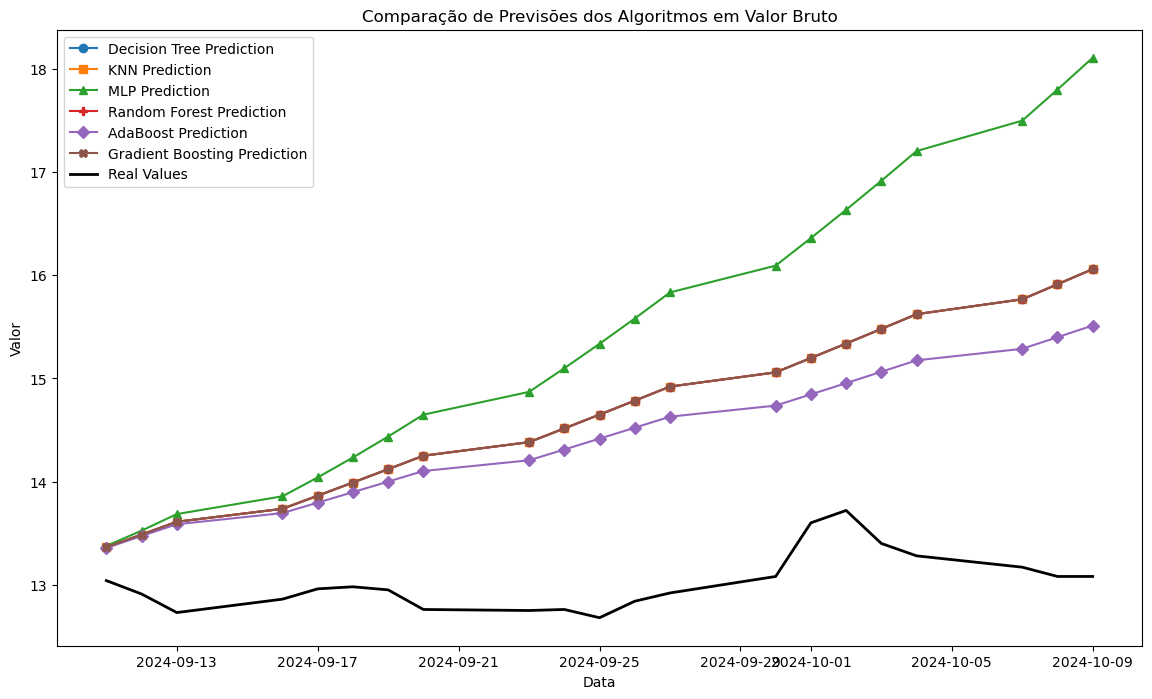

In [7]:
# Função para previsões recursivas sem data leakage
def recursive_forecast(algo, train_log_return, days_to_predict, initial_value):
    history = list(train_log_return)  # Inicia o histórico com dados de treino
    predictions = []

    for _ in range(days_to_predict):
        # Faz a previsão para o próximo ponto
        pred_log_return = algo.predict(np.array([history[-1]]).reshape(1, -1))[0]
        
        # Adiciona a previsão ao histórico para a próxima iteração
        predictions.append(pred_log_return)
        history.append(pred_log_return)

    # Converte previsões de log-retorno para valores brutos
    cumulative_predictions = np.cumsum(predictions)
    predicted_values = initial_value * np.exp(cumulative_predictions)
    return predicted_values

# Executa previsões recursivas para cada modelo
predictions_converted = {}
days_to_predict = len(test_log_return)
for algo_name, algo in algorithms.items():
    predictions_converted[algo_name] = recursive_forecast(algo, train_log_return, days_to_predict, initial_value)

# Converte o log-retorno real para valor bruto para comparação
cumulative_real_log_return = np.cumsum(test_log_return)
real_values = initial_value * np.exp(cumulative_real_log_return)

# Gráfico comparativo de previsões em valores brutos
plt.figure(figsize=(14, 8))
markers = ['o', 's', '^', 'P', 'D', 'X', 'H']  # Diferentes marcadores para cada algoritmo

for i, (algo_name, preds) in enumerate(predictions_converted.items()):
    plt.plot(test_log_return.index, preds, label=f"{algo_name} Prediction", marker=markers[i % len(markers)])

plt.plot(test_log_return.index, real_values, label="Real Values", color='black', linewidth=2)
plt.title("Comparação de Previsões dos Algoritmos em Valor Bruto")
plt.xlabel("Data")
plt.ylabel("Valor")
plt.legend()
plt.show()